### Подготовка данных

Загрузим тот же датасет и подгоним под формат удобный для pytorch

In [1]:
import idx2numpy
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
x_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-images-idx3-ubyte')).astype('float32')
y_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-labels-idx1-ubyte'))

x_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-images-idx3-ubyte')).astype('float32')
y_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-labels-idx1-ubyte'))

x_train /= 255
x_test /= 255

x_train = np.fliplr(x_train)
x_test = np.fliplr(x_test)

x_train = np.rot90(x_train, k=3, axes=(1, 2))
x_test = np.rot90(x_test, k=3, axes=(1, 2))

# x_train = x_train.reshape(x_train.shape[0], 784)
# x_test = x_test.reshape(x_test.shape[0], 784)

y_train -= 1
y_test -= 1

with open('data/emnist/emnist-letters-mapping.txt', 'r') as mapping_file:
    idx = {}
    for line in mapping_file.readlines():
        items = line.split()
        idx[int(items[0])-1] = chr(int(items[1]))

In [43]:
train_images = torch.tensor(x_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.float32)
test_images = torch.tensor(x_test, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.float32)

In [44]:
from torch.utils.data import Dataset, DataLoader

class EMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.unsqueeze(1)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
train_dataset = EMNISTDataset(train_images, train_labels)
test_dataset = EMNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: 21.0


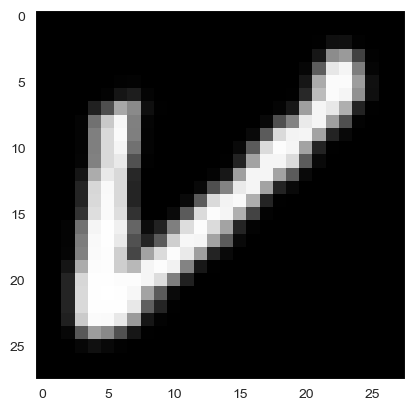

In [45]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(f"Label: {label}")
sns.set_style(style='dark')
plt.imshow(img, cmap="gray")
plt.show()

Вычисления попробуем производить на видеокарте

In [46]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [47]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_units, num_classes):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [67]:
input_size = train_images.shape[1] * train_images.shape[2]
hidden_units = 64
num_classes = 26
epochs = 10

In [68]:
model = SimpleNN(input_size, hidden_units, num_classes)

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [70]:
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.view(-1, 28*28)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 2.7830
Epoch [2/10], Loss: 2.6733
Epoch [3/10], Loss: 2.6381
Epoch [4/10], Loss: 2.6175
Epoch [5/10], Loss: 2.6034
Epoch [6/10], Loss: 2.5885
Epoch [7/10], Loss: 2.5656
Epoch [8/10], Loss: 2.5569
Epoch [9/10], Loss: 2.5392
Epoch [10/10], Loss: 2.5046


In [71]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 82.39%
